# Exploratory Data Analysis

In [148]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [68]:
trans_df = pd.read_csv('../data/credit_card_fraud_data_v2.csv')

In [149]:
trans_df.shape

(6372620, 11)

In [150]:
trans_df.columns

Index(['Time_Stamp', 'Transaction_Type', 'Amount', 'Client_Id',
       'Client_Old_Balance', 'Cleint_New_Balance', 'Merchant_Id',
       'Merchant_Old_Balance', 'Merchant_New_Balance', 'Is_Fraud',
       'Is_Flagged_Fraud'],
      dtype='object')

In [151]:
trans_df.head()

,Time_Stamp,Transaction_Type,Amount,Client_Id,Client_Old_Balance,Cleint_New_Balance,Merchant_Id,Merchant_Old_Balance,Merchant_New_Balance,Is_Fraud,Is_Flagged_Fraud
0,1,BILL-PAYMENT,9839.64,C494672677,170136.0,160296.36,M582455116,0.0,0.0,0,0
1,1,BILL-PAYMENT,1864.28,C502607876,21249.0,19384.72,C214000796,0.0,0.0,0,0
2,1,PURCHASE,181.00,C633112680,181.0,0.00,M1922059099,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C1993768127,181.0,0.00,M245426835,21182.0,0.0,1,0
4,1,BILL-PAYMENT,11668.14,C1445837831,41554.0,29885.86,M1368211346,0.0,0.0,0,0


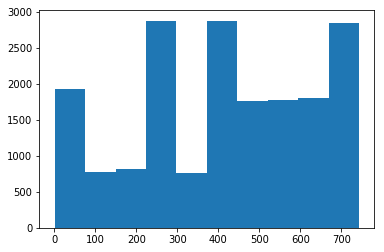

In [172]:
# Histogram of time stamps of fraud transactions
plt.hist(trans_df[trans_df.Is_Fraud == 1].Time_Stamp)
plt.show()

In [22]:
trans_df['Time_Stamp'].max()

743

### How different is Balance Difference and Amount? 

In [137]:
bal_diff = trans_df['Client_Old_Balance'] - trans_df['Cleint_New_Balance']
bal_diff = bal_diff.abs()

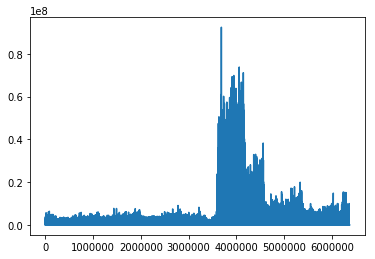

In [175]:
column_diff = (bal_diff - trans_df.Amount).abs()
plt.plot(column_diff)
plt.show()

### Number of Fraud cases that are Flagged

In [ ]:
trans_df.Is_Fraud[trans_df.Is_Flagged_Fraud == 1].sum()

### Number of Fraud Cases: 0.3 % !!!!!

In [7]:
trans_df['Is_Fraud'].sum()

18213

### Number of Unique Clients

In [8]:
trans_df['Client_Id'].unique().shape

(952147,)

### Number of Unique Merchants

In [9]:
trans_df['Merchant_Id'].unique().shape

(522360,)

### Range of Trans. Amount Values

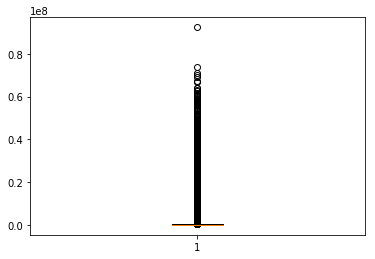

In [11]:
plt.boxplot(trans_df['Amount'])
plt.show()

In [13]:
trans_df['Amount'].max()

92445516.64

In [14]:
trans_df['Amount'].min()

0.0

In [16]:
np.sum(np.abs(trans_df['Is_Fraud'].values - trans_df['Is_Flagged_Fraud'].values))

18197

In [18]:
trans_df['Is_Flagged_Fraud'].sum()

16

### Transaction Type When Fraud

In [15]:
fraud_trans = trans_df[trans_df.Is_Fraud == 1]['Transaction_Type']

In [19]:
np.sum(fraud_trans == 'CASH_OUT')

9116

In [20]:
np.sum(fraud_trans == 'PURCHASE')

9097

### Amount Range When Fraud

In [23]:
amount_fraud = trans_df[trans_df.Is_Fraud == 1]['Amount']

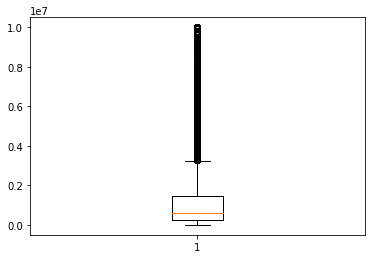

In [171]:
plt.boxplot(amount_fraud)
plt.show()

# Feature Engineering

In [279]:
# Change Trans Type to one-hot encoding
model_data = pd.get_dummies(trans_df, columns=['Transaction_Type'])

In [280]:
# Remove columns that don't matter
model_data = model_data.drop(columns=['Time_Stamp', 'Client_Id', 'Merchant_Id', 'Merchant_Old_Balance', 
                         'Merchant_New_Balance', 'Is_Flagged_Fraud'])

In [281]:
# Create new feature 
old_bal = model_data.Client_Old_Balance
purch_amt = model_data.Amount
pctg_bal = purch_amt / old_bal

# Add new feature column
model_data['%_Of_Balance'] = pctg_bal

# Remove rows where %_of_Balance == inf
model_data = model_data[model_data['%_Of_Balance'] != np.inf]

In [282]:
# Combine client balance into one 
abs_bal_diff = model_data.Cleint_New_Balance - model_data.Client_Old_Balance
abs_bal_diff = abs_bal_diff.abs()

# Add new feature column
model_data['abs_bal_diff'] = abs_bal_diff

# Remove columns
model_data = model_data.drop(columns=['Cleint_New_Balance', 'Client_Old_Balance'])

In [283]:
# Standardize non-binary columns
model_data['Amount'] = (model_data.Amount - model_data.Amount.mean())/model_data.Amount.std()
model_data['abs_bal_diff'] = (model_data.abs_bal_diff - model_data.abs_bal_diff.mean())/model_data.abs_bal_diff.std()
model_data['%_Of_Balance'] = (model_data['%_Of_Balance'] - model_data['%_Of_Balance'].mean())/model_data['%_Of_Balance'].std()

In [284]:
# Remove rows where null
model_data.dropna(inplace=True)

# Undersample majority class for balanced dataset

In [285]:
nonfraud_trans = model_data[model_data.Is_Fraud == 0]
fraud_trans = model_data[model_data.Is_Fraud == 1]

In [286]:
nonfraud_trans_idxs = np.random.choice(nonfraud_trans.index, fraud_trans.shape[0], replace=False)
nonfraud_trans = nonfraud_trans.loc[nonfraud_trans_idxs]

X = pd.concat([nonfraud_trans, fraud_trans])

In [288]:
y = X.Is_Fraud
X = X.drop(columns=['Is_Fraud'])

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y)

# Run Basic Logistic Regression 

In [291]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import cross_validate

model = LogisticRegressionCV(penalty='l2', cv=5)
model = model.fit(X_train, y_train)

In [292]:
from sklearn.metrics import roc_auc_score, f1_score, roc_curve

In [293]:
y_pred = model.predict_proba(X_test)
roc_auc_score(y_test, y_pred[:,1])

/usr/local/Cellar/python3/3.5.2_3/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/linear_model/base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)


0.9913331797358949

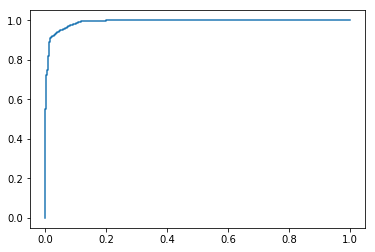

In [294]:
# Plot ROC Curve
fpr, tpr, thres = roc_curve(y_test, y_pred[:,1])
plt.plot(fpr, tpr)
plt.show()

In [295]:
model.score(X_test, y_test)

0.9490424829407881

In [296]:
y_hat = model.predict(X_test)
f1_score(y_test, y_hat)

0.948766183467965

# SVM using RBF Kernel

In [297]:
from sklearn.svm import SVC

In [298]:
svm_model = SVC(probability=True)
svm_model = svm_model.fit(X_train, y_train)

/usr/local/Cellar/python3/3.5.2_3/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [299]:
y_pred = svm_model.predict_proba(X_test)
roc_auc_score(y_test, y_pred[:,1])

0.9894464023676294

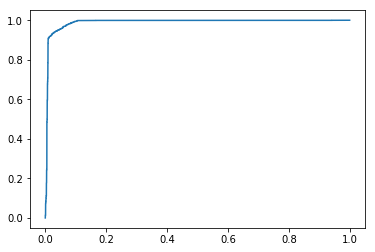

In [300]:
# Plot ROC Curve
fpr, tpr, thres = roc_curve(y_test, y_pred[:,1])
plt.plot(fpr, tpr)
plt.show()

In [303]:
svm_model.score(X_test, y_test)

0.953664979088708

In [302]:
y_hat = svm_model.predict(X_test)
f1_score(y_test, y_hat)

0.9531023727303107